#**Importing Libraries**

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
from sklearn.model_selection import train_test_split, GridSearchCV
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
!pip install xgboost==1.7.6
!pip install lightgbm

from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from numpy import mean
from numpy import absolute
from numpy import sqrt
import xgboost as xgb
from collections import OrderedDict
import time
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import HistGradientBoostingRegressor

from lightgbm import LGBMRegressor
!pip install catboost
!pip install shap
!pip install tensorflow
!pip install keras
import shap
import shap.plots
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

#**Read Dataset +  Train/Test**

In [ ]:
df = pd.read_csv('DS_LPLevel_10100_Het_CFEGN_v3.csv')
target = 'Lightpath GSNR'
# df.head()
# df.describe()
# df.info()
# df.shape

In [ ]:
X = df.drop([target], axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_data_points = df.shape[0]
num_features = X.shape[1]

#**Util Functions**

##**Setters and Getters**

In [ ]:
def saveResults(y_test,y_pred,index,nb_features,tt,it,nb_splits):
  r2 = float(format((r2_score(y_test,y_pred)),'.3f'))
  rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
  mae = float(format((mean_absolute_error(y_test , y_pred)),'.3f'))

  average_it,max_it,min_it = it;
  average_it=format(average_it,'.3f')
  max_it=format(max_it,'.3f')
  min_it=format(min_it,'.3f')

  dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [mae], 'r2' : [r2],'nb_features':[nb_features],'training time (s)':[tt],'average inference time/data point (ms)':[average_it],'max inference time/data point (ms)':[max_it],'min inference time/data point (ms)':[min_it],'nb of splits':[nb_splits]})
  if os.path.isfile('results.csv'):
    dt.to_csv('results.csv',mode="a", header=False)
  else:
        dt.to_csv('results.csv')
  get_results()

In [ ]:
def addResults(rmse,mae,r2,index,nb_features,tt,it,nb_splits):
  if len(it) == 3:
      avg,max,min = it
      dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [mae], 'r2' : [r2],'nb_features':[nb_features],'training time':[tt],'average inference time/data point':[avg],'max inference time/data point':[max],'min inference time/data point':[min],'nb splits':[nb_splits]})
  else:
    dt = pd.DataFrame({'type': [index],'rmse': [rmse], 'mae': [mae], 'r2' : [r2],'nb_features':[nb_features],'training time':[tt],'average inference time/data point':[it],'max inference time/data point':['-'],'min inference time/data point':['-'],'nb splits':[nb_splits]})
  if os.path.isfile('results.csv'):
    dt.to_csv('results.csv',mode="a", header=False)
  else:
        dt.to_csv('results.csv')

In [ ]:
def get_results(file='results.csv'):
  data = pd.read_csv(file)
  return data.iloc[:,-10:]

In [ ]:
def print_results(file='results.xlsx'):
  data = pd.read_excel(file)
  return data.iloc[:,-11:]

In [ ]:
def get_features():
  data = pd.read_csv('selected_features.csv')
  return data.iloc[:,-3:]

In [ ]:
import csv

def save_features(feature_selection_types,selected_features):
  file_exists = os.path.exists('selected_features.csv')
  with open('selected_features.csv', mode='a', newline='') as file:
      writer = csv.writer(file)
      if not file_exists:
          writer.writerow(['Feature_Selection_Method','Nb_Features', 'Selected_Features'])
      for idx, selected_feature_list in enumerate([selected_features]):
          method_name = feature_selection_types
          nb_features = len(selected_features)
          selected_features_str = ', '.join(selected_feature_list)
          writer.writerow([method_name, nb_features,selected_features_str])

In [ ]:
def get_tuned_params():
  data = pd.read_csv('tuned_params.csv')
  return data.iloc[:,-3:]

In [ ]:
import csv

def save_tuning_params(feature_selection_types,tuned_params):
  file_exists = os.path.exists('tuned_params.csv')
  with open('tuned_params.csv', mode='a', newline='') as file:
      writer = csv.writer(file)
      if not file_exists:
          writer.writerow(['Feature_Selection_Method','Nb_Params', 'Selected_Params'])
      for idx, selected_feature_list in enumerate([tuned_params]):
          method_name = feature_selection_types
          nb_params = len(tuned_params)
          writer.writerow([method_name, nb_params,tuned_params])

In [ ]:
def calc_inference_time(model,data_points=X.to_numpy(),flag='fit'): #flag=0 means already performed .fit so gives avg,max,min else gives avg only
  if flag=='no_fit' :
    model.fit(X_train,y_train)

  inference_times = []
  for data_point in data_points:
          start_time = time.time()
          prediction = model.predict(data_point.reshape(1, -1))
          end_time = time.time()
          inference_time = (end_time - start_time) * 1000
          inference_times.append(inference_time)

  average_inference_time = np.mean(inference_times)
  max_inference_time = np.max(inference_times)
  min_inference_time = np.min(inference_times)
  return average_inference_time,max_inference_time, min_inference_time

In [ ]:
def features_summary (model) :
    model_features = pd.read_csv("selected_features.csv")

    selected_features_list = [set(feature.strip() for feature in features.split(",")) for features in model_features["Selected_Features"]]

    features_dict = {}
    for idx, features in enumerate(selected_features_list):
        for feature in features:
            if feature not in features_dict:
                features_dict[feature] = [0] * len(model_features)
            features_dict[feature][idx] = 1

    selected_features_df = pd.DataFrame(features_dict)

    selected_features_df.insert(0, "Method", model_features["Feature_Selection_Method"])

    plt.figure(figsize=(10,6))
    sns.heatmap(selected_features_df.set_index("Method"), cmap="Blues", cbar=False, xticklabels="auto", yticklabels="auto")
    plt.ylabel("Methods")
    plt.yticks(rotation=0)
    plt.xlabel("Selected Features")
    plt.title(f"Selected Features of {model} after Feature Selection")
    plt.tight_layout()
    plt.savefig("selected_features_heatmap.png")
    plt.show()


##**Train Feature Selection Features + Hypertuning**

In [ ]:
def train_selected_features_with_hypertuning(selected_features,fs,model='xgb'):
  if model=='lgb':
    return train_lgb_hypertune(selected_features,fs)
  elif model == 'xgb':
    return train_xgb_hypertune(selected_features,fs)
  elif model == 'cbr':
    return train_cb_hypertune(selected_features,fs)

In [ ]:
def train_xgb_hypertune (selected_features,fs_type) :
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    save_features(fs_type,selected_features)
    nb_features = len(selected_features)

    xgb = XGBRegressor()
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    params = {
                  'objective':['reg:squarederror'],
                  'learning_rate': [0.01, 0.05, 0.1],
                  'max_depth': [3,6,8],#3
                  'min_child_weight': [1,3,5],
                  'subsample': [0.3,0.6,0.8],
                  'n_estimators': [300,500],
                  'reg_alpha': [0.1,0.2,0.5],
                  'reg_lambda': [0.1,0.2,0.5],
                  'gamma': [0.1, 0.2, 0.5],
    }

    grid_search = GridSearchCV(xgb, params, cv=cv,scoring = 'r2')
    grid_search.fit(X_train_selected, y_train)
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    save_tuning_params(fs_type,best_params)
    best_reg = grid_search.best_estimator_

    best_xgb_model = XGBRegressor(**best_params)

    start_time = time.time()
    best_xgb_model.fit(X_train_selected, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    inference_time_per_data_point = calc_inference_time(best_xgb_model,data_points=X[selected_features].to_numpy())

    y_pred = best_xgb_model.predict(X_test_selected)
    nb_splits = calculate_xgb_splits(best_xgb_model)
    joblib.dump(best_xgb_model, 'xgb_model.pkl')
    saveResults(y_test,y_pred,fs_type,nb_features,training_time,inference_time_per_data_point,nb_splits)
    return get_results()

In [ ]:
def train_lgb_hypertune (selected_features,fs_type) :
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    save_features(fs_type,selected_features)
    nb_features = len(selected_features)

    lgb = LGBMRegressor()
    cv = KFold(n_splits=5, random_state=42, shuffle=True)

    params = {
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100,300,500],
        'max_depth': [3,6,8],
        'num_leaves':[6,8,15,32],
        'min_child_samples': [5,10,15],
        'lambda_l1':[0.1, 0.2, 0.5], 'lambda_l2':[0.1,0.2,0.5]
    }

    grid_search = GridSearchCV(lgb, params, cv=cv,scoring = 'r2')
    grid_search.fit(X_train_selected, y_train,eval_set=[(X_test_selected, y_test)])
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    save_tuning_params(fs_type,best_params)

    best_lgb_model = LGBMRegressor(**best_params,early_stopping_rounds=10)

    start_time = time.time()
    best_lgb_model.fit(X_train_selected, y_train,eval_set=[(X_test_selected, y_test)])
    end_time = time.time()

    training_time = end_time - start_time
    inference_time_per_data_point = calc_inference_time(best_lgb_model,data_points=X[selected_features].to_numpy())

    best_reg = grid_search.best_estimator_

    y_pred = best_lgb_model.predict(X_test_selected)
    nb_splits = calculate_lgb_splits(best_lgb_model)
    joblib.dump(best_lgb_model, 'lgb_model.pkl')
    saveResults(y_test,y_pred,fs_type,nb_features,training_time,inference_time_per_data_point,nb_splits)
    return get_results()

In [ ]:
def train_cb_hypertune (selected_features,fs_type) :
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    save_features(fs_type,selected_features)
    nb_features = len(selected_features)

    params = {
        'iterations': [300, 500, 1000],
        'learning_rate': [0.05,0.1],
        'depth': [3,6,8],
        'l2_leaf_reg': [0.1,0.2, 0.5],
    }
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cbr = CatBoostRegressor()
    grid_search = GridSearchCV(estimator=cbr, param_grid=params, scoring='neg_mean_squared_error', cv=cv)


    grid_search = GridSearchCV(cbr, params, cv=cv,scoring = 'r2')
    grid_search.fit(X_train_selected, y_train,early_stopping_rounds=10)
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    save_tuning_params(fs_type,best_params)

    best_cb_model = CatBoostRegressor(**best_params)

    start_time = time.time()
    best_cb_model.fit(X_train_selected, y_train)
    end_time = time.time()

    training_time = end_time - start_time
    inference_time_per_data_point = calc_inference_time(best_cb_model,data_points=X[selected_features].to_numpy())

    y_pred = best_cb_model.predict(X_test_selected)
    nb_splits = calculate_cb_splits(best_cb_model)
    joblib.dump(best_cb_model, 'cb_model.pkl')

    saveResults(y_test,y_pred,fs_type,nb_features,training_time,inference_time_per_data_point,nb_splits)
    return get_results()

In [ ]:
def train_prepared_model (selected_features,params,fs_type,fs_message) :
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    nb_features = len(selected_features)

    if fs_type == 'cbr':
      model = CatBoostRegressor(**params,early_stopping_rounds=10)
    if fs_type == 'xgb':
      model = XGBRegressor(**params,early_stopping_rounds=10)
    if fs_type == 'lgb':
      model = LGBMRegressor(**params,early_stopping_rounds=10)

    start_time = time.time()
    if fs_type == 'xgb':
       model.fit(X_train_selected, y_train, eval_set=[(X_test_selected, y_test)],verbose=False)
    else :
       model.fit(X_train_selected, y_train, eval_set=[(X_test_selected, y_test)])
    end_time = time.time()

    training_time = end_time - start_time
    inference_time_per_data_point = calc_inference_time(model,data_points=X[selected_features].to_numpy())

    y_pred = model.predict(X_test_selected)

    if fs_type == 'cbr':
      nb_splits = calculate_cb_splits(model)
    if fs_type == 'xgb':
      nb_splits = calculate_xgb_splits(model)
    if fs_type == 'lgb':
      nb_splits = calculate_lgb_splits(model)

    saveResults(y_test,y_pred,fs_message,nb_features,training_time,inference_time_per_data_point,nb_splits)
    return get_results()

##**Complexity and Number of splits**

In [ ]:
def calculate_xgb_splits (xgb) :
    booster = xgb.get_booster()
    trees_strings = booster.get_dump(dump_format='text')
    total_splits = 0
    for tree_string in trees_strings:
      n_nodes = len(tree_string.split('\n')) - 1
      n_leaves = tree_string.count('leaf')
      total_splits += n_nodes - n_leaves
    print('total_splits:',total_splits)
    return total_splits

In [ ]:
def calculate_lgb_splits (lgb) :
    booster = lgb.booster_
    trees_strings = booster.dump_model()

    total_splits = 0
    for tree_string in trees_strings['tree_info']:
        n_nodes = tree_string['num_leaves'] - 1
        total_splits += n_nodes

    print("Total number of splits:", total_splits)
    return total_splits

In [ ]:
from catboost import CatBoostRegressor

def calculate_cb_splits(catboost_model):
    num_trees =  catboost_model.get_params()['iterations']
    total_splits = 0

    for tree_idx in range(num_trees):
        if tree_idx < 692 :
          leaf_indexes = catboost_model.calc_leaf_indexes(X,ntree_start=tree_idx, ntree_end=tree_idx+1 )

        num_leaves = len(set(leaf_indexes.ravel()))

        num_splits = num_leaves - 1
        total_splits += num_splits

    print('total_splits:', total_splits)
    return total_splits

# **Regression Models**

##**Boosting Models**

###**XGB**

In [ ]:
xgb = XGBRegressor()
cv = KFold(n_splits=5, random_state=42, shuffle=True)

#LPLevel Dataset Params
params = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,0.1], #0.1
              'max_depth': [3,6,8,12],#6
              'min_child_weight': [1,3],#3
              'subsample': [0.3,0.8], #0.8
              'n_estimators': [100,200,300,500], #500
              'reg_alpha': [0, 0.1, 0.5],#0.5
              'reg_lambda': [0, 0.1, 0.5],#0.5
              'gamma': [0, 0.1, 0.2],#0.2
           }

grid_search = GridSearchCV(xgb, params, cv=cv,scoring = 'r2')

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

best_reg = grid_search.best_estimator_

y_pred = best_reg.predict(X_test)
saveResults(y_test,y_pred,"XGB GS",X.shape[1],training_time,inference_time_per_data_point)
get_results()

In [ ]:
#After Hypertuning
params={'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,
       'reg_alpha':0.5,'reg_lambda':0.5,'gamma':0.2}
xgb = XGBRegressor(**params)

start_time = time.time()
xgb.fit(X_train, y_train,early_stopping_rounds=10,eval_set=[(X_train, y_train), (X_test, y_test)],verbose=False)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(xgb)

y_pred_xgb = xgb.predict(X_test)
nb_splits = calculate_xgb_splits(xgb)


joblib.dump(xgb, 'xgb_model.pkl')

saveResults(y_test,y_pred_xgb,"XGB",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

###**GB**

In [ ]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
param_grid = {
    'learning_rate': [0.01, 0.1], #0.1
    'n_estimators': [100,300,500], #500
    'max_depth': [3,6,8], #3
    'subsample' : [0.3,0.6,0.8] #0.8
}
gb = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
best_reg = grid_search.best_estimator_
y_pred = best_reg.predict(X_test)
nb_splits = calculate_splits(grid_search)

saveResults(y_test,y_pred,"GB Regressor with GS",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(learning_rate=0.1, subsample=0.8, max_depth=3,n_estimators=500)

start_time = time.time()
gb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(gb)

y_pred_gb = gb.predict(X_test)
nb_splits = calculate_splits(gb)
joblib.dump(gb, 'gb_model.pkl')

saveResults(y_test,y_pred_gb,"GB Regressor",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

###**LGB**

In [ ]:
from lightgbm import LGBMRegressor
cv = KFold(n_splits=5, random_state=42, shuffle=True)
param_grid = {
    'learning_rate': [0.01, 0.1], #0.1
    'n_estimators': [100, 300,500], #500
    'max_depth': [3,6,8], #3
    'num_leaves':[6,8,15,32,40],#8
    'min_child_samples': [5,10,15],#5
    'lambda_l1':[0.1,0.2], 'lambda_l2':[0.1,0.2]
}

lgb = LGBMRegressor()
grid_search = GridSearchCV(estimator=lgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

start_time = time.time()
grid_search.fit(X_train, y_train,eval_set=[(X_test, y_test)])
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
best_reg = grid_search.best_estimator_
y_pred = best_reg.predict(X_test)
nb_splits = calculate_lgb_splits(grid_search)

saveResults(y_test,y_pred,"LGB Regressor GS",X.shape[1],training_time,inference_time_per_data_point,grid_search)
get_results()

In [ ]:
from lightgbm import LGBMRegressor

params={'lambda_l1': 0.2, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 5,
        'n_estimators': 500, 'num_leaves': 8,"verbosity" : -1}

lgb =LGBMRegressor(**params,early_stopping_rounds=10)
start_time = time.time()
lgb.fit(X_train, y_train , eval_set=[(X_test, y_test)])
end_time = time.time()
training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(lgb)

y_pred_lgb = lgb.predict(X_test)
nb_splits = calculate_lgb_splits(lgb)
joblib.dump(lgb, 'lgb_model.pkl')

saveResults(y_test,y_pred_lgb,"LGB Regressor",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

###**CatBoost**

In [ ]:
from catboost import CatBoostRegressor
cv = KFold(n_splits=5, random_state=42, shuffle=True)
param_grid = {
    'loss_function':['RMSE'],
    'iterations': [300,500,1000], #1000
    'learning_rate': [0.01,0.05,0.1], #0.05
    'depth': [3, 6,8], #6
    'l2_leaf_reg': [0.2,0.5], #0.5
    'border_count':[128,256,512]
}

cbr = CatBoostRegressor()
grid_search = GridSearchCV(estimator=cbr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(grid_search)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
best_reg = grid_search.best_estimator_
y_pred = best_reg.predict(X_test)
nb_splits = calculate_cb_splits(cbr)

saveResults(y_test,y_pred,"CAT Boost Regressor GS",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

In [ ]:
from catboost import CatBoostRegressor, Pool
parameters= {'border_count': 256, 'depth': 6, 'iterations': 1000, 'learning_rate': 0.05, 'loss_function': 'RMSE','l2_leaf_reg': 0.5}

cbr = CatBoostRegressor(**parameters,early_stopping_rounds=10)
start_time = time.time()
cbr.fit(X_train, y_train, eval_set=[(X_test, y_test)])
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(cbr)

y_pred_cb = cbr.predict(X_test)
nb_splits = calculate_cb_splits(cbr)
joblib.dump(cbr, 'cb_model.pkl')

saveResults(y_test,y_pred_cb,"CAT Boost Regressor",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

###**HGB**

In [ ]:
#After Hypertuning
params = {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 500}

hgb = HistGradientBoostingRegressor(**params,loss="squared_error", verbose=2, early_stopping=True)

start_time = time.time()
hgb.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(hgb)

y_pred_hgb = hgb.predict(X_test)

nb_splits = calculate_hgb_splits(hgb)
joblib.dump(hgb, 'hgb_model.pkl')

saveResults(y_test,y_pred_hgb,"HGB with tuning",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

##**Other ML Regressor Models**

###**Decision Tree Regressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state = 42)
start_time = time.time()
dt.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(dt)

y_pred = dt.predict(X_test)
nb_splits = calculate_dt_splits(dt)

saveResults(y_test,y_pred,"Decision Tree",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

###**Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfc = RandomForestRegressor()

start_time = time.time()
rfc.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(rfc)

y_pred = rfc.predict(X_test)
nb_splits = calculate_splits(rfc)

saveResults(y_test,y_pred,"Random Forest",X.shape[1],training_time,inference_time_per_data_point,nb_splits)
get_results()

###**Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

start_time = time.time()
lr.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(lr)

y_pred = lr.predict(X_test)
saveResults(y_test,y_pred,"Linear Regression",X.shape[1],training_time,inference_time_per_data_point,'-')
get_results()

##**ANN Model**

Keras Knowledge Distillation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
!pip install hyperopt
!pip install keras

import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

###Hyper-Opt

In [ ]:
import numpy as np
from hyperopt import fmin, tpe, hp
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming you have x_train, y_train defined
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(params):
    model = Sequential()
    model.add(Dense(params['first_layer_units'], kernel_initializer=params['kernel_initializer'], input_shape=x_train.shape[1:]))

    for i in range(params['num_layers']):
        model.add(Dense(params['layer_units'], kernel_initializer=params['kernel_initializer'], activation=params['activation']))

    model.add(Dense(1, kernel_initializer=params['kernel_initializer'], activation='linear'))

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError(name="rmse"), keras.metrics.MeanAbsoluteError(name="mae")
])

    return model

def objective(params):
    model = create_model(params)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    history = model.fit(x_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'], validation_data=(x_test, y_test), verbose=0)
    val_loss = history.history['val_loss'][-1]
    return val_loss

# Define the search space
space = {
    'first_layer_units': hp.choice('first_layer_units', [16,32,64]),
    'layer_units': hp.choice('layer_units', [16, 32,64, 128]),
    'num_layers': hp.choice('num_layers', [3,4,5,8,10]),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
    'kernel_initializer': hp.choice('kernel_initializer', ['normal', 'uniform']),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'epochs': hp.choice('epochs', [100,200,300]),
    'batch_size': hp.choice('batch_size', [16,32,64]),
}

In [ ]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=15)
print("Best hyperparameters:", best)

After getting Best Parameters

In [ ]:
best = {'activation': 'relu','batch_size': 16, 'epochs': 200, 'first_layer_units': 16, 'kernel_initializer': 'uniform', 'layer_units': 32, 'learning_rate': 0.00039844539525204923, 'num_layers':8}

model_ts = create_model(best)
history = model_ts.fit(x_train, y_train, epochs=best['epochs'], validation_data=(x_test, y_test), verbose=1)

In [ ]:
best_result=model_ts.evaluate(x_test, y_test)
print(best_result)
model_ts.summary()

###Keras Knoweldge Distillation

In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        Dense(16,  kernel_initializer='uniform',input_shape=x_train.shape[1:]),
        Dense(32, kernel_initializer='uniform', activation = 'relu'),
        Dense(32, kernel_initializer='uniform', activation = 'relu'),
        Dense(32, kernel_initializer='uniform', activation = 'relu'),
        Dense(32, kernel_initializer='uniform', activation = 'relu'),
        Dense(32,  kernel_initializer='uniform',activation = 'relu'),
        Dense(32, kernel_initializer='uniform', activation = 'relu'),
        Dense(32, kernel_initializer='uniform', activation = 'relu'),
        Dense(32, kernel_initializer='uniform', activation = 'relu'),
        Dense(1, kernel_initializer='uniform', activation='linear'),
    ],
    name="teacher",
)

# Create the student
student = keras.Sequential(
    [
        Dense(16, kernel_initializer='uniform', input_shape=x_train.shape[1:]),
        Dense(16, kernel_initializer='uniform', activation = 'relu'),
        Dense(16, kernel_initializer='uniform', activation='relu'),
        Dense(16, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='linear'),
    ],
    name="student",
)

student_scratch = keras.models.clone_model(student)

In [ ]:
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse"),
        keras.metrics.MeanAbsoluteError(name="mae"),
        # r2
    ]
)

# Train and evaluate teacher on data.
start_time = time.time()
teacher.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test),  batch_size = 16,validation_split = 0.2)
end_time = time.time()
training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(teacher,data_points=X.to_numpy())

teacher_evaluate=teacher.evaluate(x_test, y_test)
teacher.save('teacher_KD.keras')

rmse=teacher_evaluate[1]
mae=teacher_evaluate[2]
# r_2=teacher_evaluate[3]
print(teacher_evaluate)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
addResults(rmse,mae,'r_2','ANN Teacher',training_time,inference_time_per_data_point)

get_results()

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    student_loss_fn=keras.losses.MeanSquaredError(),
    distillation_loss_fn=keras.losses.MeanSquaredError(), # MSE for distillation
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse"),
        keras.metrics.MeanAbsoluteError(name="mae")
        # r2
    ],
    alpha=0.05, temperature=20,
)

# Distill teacher to student
start_time = time.time()
distiller.fit(x_train, y_train, epochs=200,validation_data=(x_test, y_test), batch_size = 16,validation_split = 0.2)
end_time = time.time()
training_time = end_time - start_time
inference_time_per_data_point = calc_inference_time(student)

# Evaluate student on test dataset
eval_results = distiller.evaluate(x_test, y_test)

rmse=eval_results[0]
mae=eval_results[1]
# r_2=eval_results[2]
print(eval_results)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
# print(f"R^2: {r_2}")
addResults(rmse,mae,'r_2','Student KD',training_time,inference_time_per_data_point)
get_results()

#**SHAP Explanations**

**Model should already be trained (from above)**

* (replace model with either lgb or xgb or cbr)*

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(xgb).shap_interaction_values(X_test)
shap.initjs()

###***Global Explanations show importance of each feature***

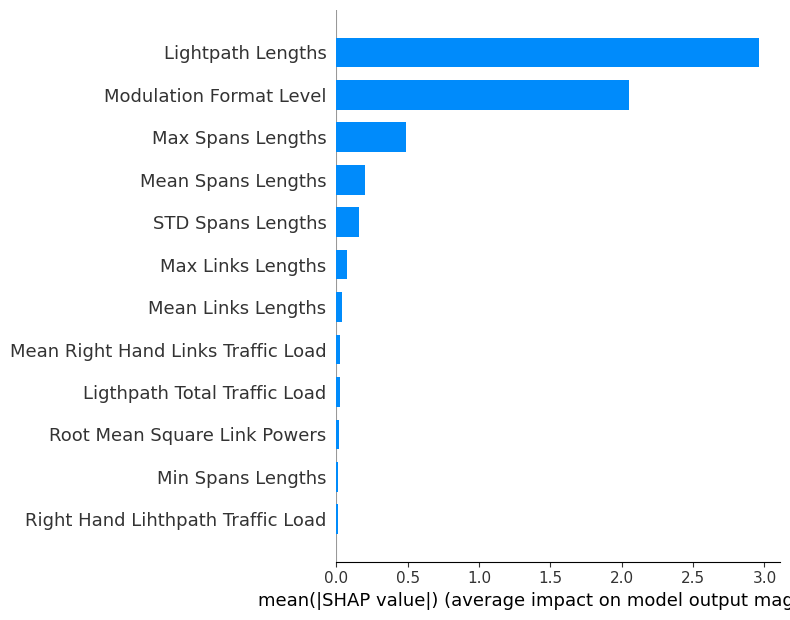

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

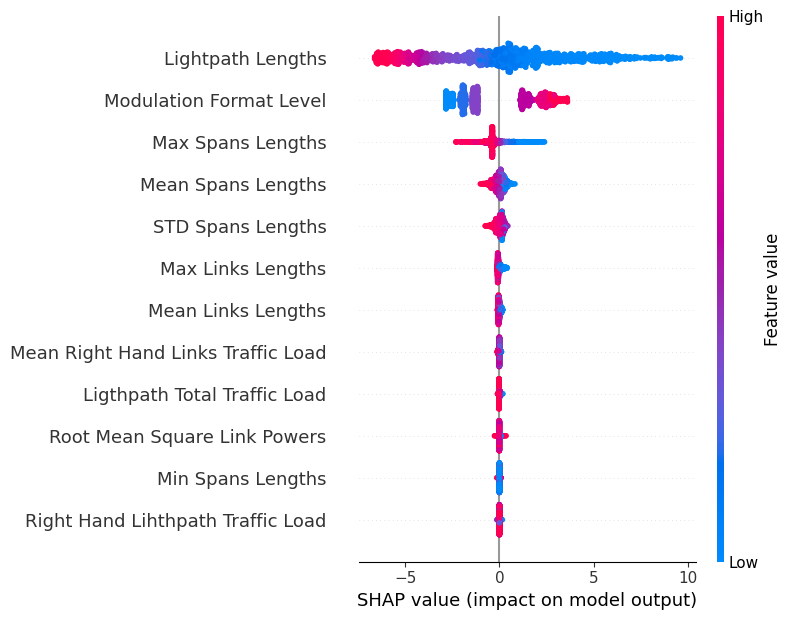

In [ ]:
shap.summary_plot(shap_values, X_test)


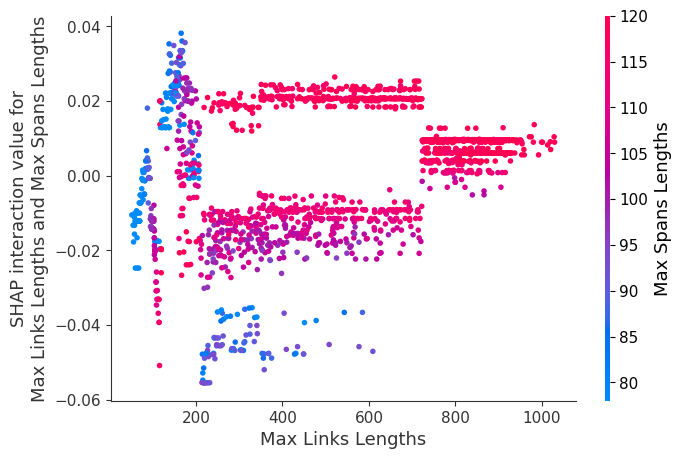

In [ ]:
#
# shap.dependence_plot("Lightpath Lengths", shap_values, X_test)
# shap.dependence_plot("Modulation Format Level", shap_values, X_test)
# shap.dependence_plot("Max Spans Lengths", shap_values, X_test)

# shap.dependence_plot(("Lightpath Lengths","Modulation Format Level"), shap_interaction_values, X_test)
shap.dependence_plot(("Max Links Lengths","Max Spans Lengths"), shap_interaction_values, X_test)


###***Local Shap Individual Predictions***

In [ ]:
shap.initjs()
observation=1
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:],matplotlib=True,show=False)
# shap.force_plot(explainer.expected_value, shap_values, X_test)
shap.force_plot(explainer.expected_value, shap_values[observation,:], X_test.iloc[observation,:])
# plt.savefig("shap_force_plot2.jpg")

In [ ]:
shap.initjs()
i=5
def shap_plot(j):
    # explainerModel = shap.TreeExplainer(lgb)
    # shap_values_Model = explainerModel.shap_values(X_test)
    # p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_test.iloc[[j]],matplotlib=True,show=False)
    p= shap.decision_plot(explainer.expected_value, shap_values[j], X_test.iloc[[j]])
    return(p)


shap_plot(i)
plt.savefig(f'shap_force_plot_{i}.jpg')

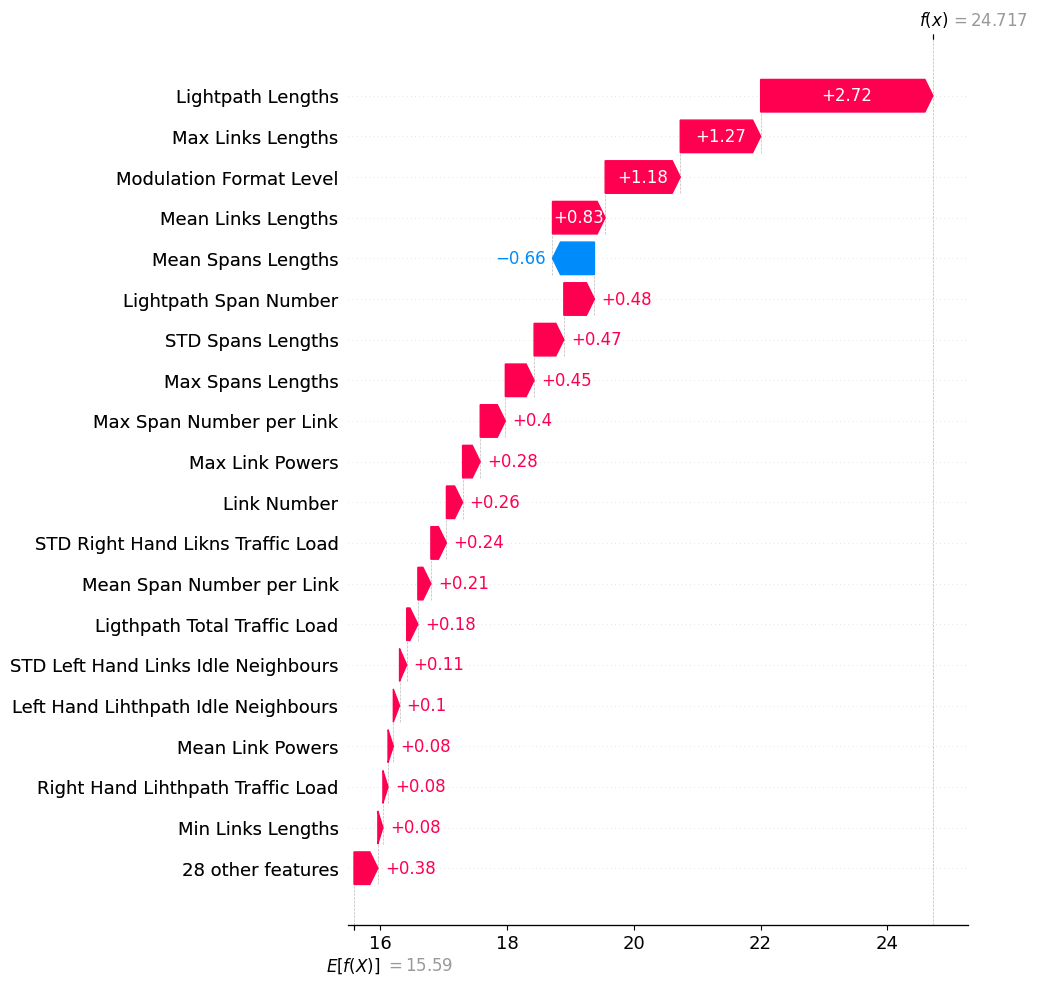

In [ ]:
shap.waterfall_plot(shap.Explanation(values=shap_values[1],feature_names=X_train.columns, base_values=cbr.predict(X_train).mean()), max_display=20)

#**Feature Selection using SHAP**
**Model should already be trained + fed into the SHAP explainer (from above)**

*(can only take lgb or xgb or cbr)*

In [ ]:
feature_selection_type='xgb'
feature_selection_model=xgb

##**Method 1: Powershap**

In [ ]:
! pip install powershap
from powershap import PowerShap

In [ ]:
model_ps = feature_selection_model
if feature_selection_type == 'cbr':
  selector_cbr = CatBoostRegressor()
  selector = PowerShap(
    model = selector_cbr,
    automatic=True, limit_automatic=100)
else:
  selector = PowerShap(
      model = model_ps,
      automatic=True, limit_automatic=100)

selector.fit(X_train, y_train,early_stopping_rounds=10)

selected_features_ps = selector.transform(X_train).columns
print(selector._processed_shaps_df)
train_selected_features_with_hypertuning(selected_features_ps,f'PowerShap for {feature_selection_type}',model=feature_selection_type)

###**Saved Powershap Models**
(After performing PowerShap and getting the set of features and optimal params for each)

**xgb**

In [ ]:
params_xgb = {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,'reg_alpha':0.1,'reg_lambda':0.1,'gamma':0.2}
selected_features_xgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths', 'STD Spans Lengths', 'Ligthpath Total Traffic Load', 'Mean Links Lengths', 'Max Links Lengths', 'Lightpath Lengths', 'Root Mean Square Link Powers']
X_train, X_test, y_train, y_test = train_test_split(X[selected_features_xgb], y, test_size=0.2, random_state=42)

train_prepared_model (selected_features_xgb,params_xgb,'xgb',f'PowerShap for XGB')
get_results()

**lgb**

In [ ]:
params_lgb={'lambda_l1': 0.2, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 10, 'n_estimators': 500, 'num_leaves': 15,'verbosity':-1}
selected_features_lgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths', 'Min Spans Lengths', 'STD Spans Lengths', 'Mean Links Lengths',
                       'Max Links Lengths', 'Min Links Lengths', 'Lightpath Lengths', 'Mean Link Powers','Root Mean Square Link Powers','Right Hand Lihthpath Traffic Load', 'Mean Right Hand Links Traffic Load']

train_prepared_model (selected_features_lgb,params_lgb,'lgb',f'PowerShap for LGB')

**cb**

In [ ]:
params_cb = {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 0.5, 'learning_rate': 0.05}
selected_features_cb=['Modulation Format Level', 'Link Number', 'Mean Spans Lengths', 'Max Spans Lengths','Min Spans Lengths', 'STD Spans Lengths',
                      'Ligthpath Total Traffic Load', 'Mean Links Lengths', 'Max Links Lengths', 'Min Links Lengths', 'STD Links Lengths', 'Lightpath Lengths',
                      'Mean Span Number per Link', 'Max Span Number per Link', 'Lightpath Span Number', 'Mean Link Powers', 'Root Mean Square Link Powers',
                      'Min Link Powers', 'STD Link Powers']

train_prepared_model (selected_features_cb,params_cb,'cbr',f'PowerShap for CatBoost')

##**Shaphypetune**
- Method 2: **Boruta**
- Method 3: **RFE**
- Method 4: **RFA**

In [ ]:
! pip install shap-hypetune
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta

In [ ]:
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
param_grid = {
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,0.1], #0.1
              'max_depth': [3,6,8],#6
              'min_child_weight': [1,3,5],#3
              'subsample': [0.3,0.8], #0.8
              'n_estimators': [100,300,500], #500
              'reg_alpha': [0.1,0.2, 0.5],#0.5
              'reg_lambda': [ 0.1,0.2, 0.5],#0.5
              'gamma': [ 0.1, 0.2,0.5],#0.2
           }
xgb_model = XGBRegressor()
X_train, X_valid, y_train, y_valid = train_test_split(
X_train, y_train, test_size=0.2, shuffle=True, random_state=33)
model = BoostSearch(xgb_model, param_grid=param_grid, greater_is_better=True)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='mae', early_stopping_rounds=3, verbose=0)
y_pred =  model.estimator_.predict(X_test)
print( model.best_params_)
saveResults(y_test,y_pred,"XGB with BoostSearch",'training_time','inference_time_per_data_point')
get_results()

In [ ]:
X_regr_train, X_regr_valid, y_regr_train, y_regr_valid = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

###**Boruta**

In [ ]:
model_boruta = BoostBoruta(feature_selection_model, max_iter=200, perc=100,importance_type='shap_importances', train_importance=False)
model_boruta.fit(X_regr_train, y_regr_train, eval_set=[(X_regr_valid, y_regr_valid)],eval_metric='mae')

selected_features_br = (model_boruta.transform(X_regr_valid).columns) #to see which features

train_selected_features_with_hypertuning(selected_features_br,f'Boruta + Tuning',model=feature_selection_type)
get_results()

####**Saved Boruta Models**
(After performing Boruta and getting the set of features and optimal params for each)

**XGB**

In [ ]:
params_xgb ={'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8,'reg_alpha':0.1,'reg_lambda':0.1,'gamma':0.2}
selected_features_xgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths', 'Min Spans Lengths', 'STD Spans Lengths', 'Ligthpath Total Traffic Load', 'Mean Links Lengths', 'Max Links Lengths',
                       'Min Links Lengths', 'Lightpath Lengths', 'Root Mean Square Link Powers','Right Hand Lihthpath Traffic Load', 'Mean Right Hand Links Traffic Load']
train_prepared_model (selected_features_xgb,params_xgb,'xgb',f'Boruta for XGB')

**LGB**

In [ ]:
params_lgb={'lambda_l1': 0.2, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 5, 'n_estimators': 500, 'num_leaves': 15,'verbosity':-1}

selected_features_lgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths', 'Min Spans Lengths', 'STD Spans Lengths', 'Ligthpath Total Traffic Load', 'Mean Links Lengths', 'Max Links Lengths',
                       'Min Links Lengths', 'STD Links Lengths', 'Lightpath Lengths', 'Root Mean Square Link Powers','Right Hand Lihthpath Traffic Load', 'Mean Right Hand Links Traffic Load']
train_prepared_model (selected_features_lgb,params_lgb,'lgb',f'Boruta for LGB')

###**RFE**

In [ ]:
model_rfe = BoostRFE(feature_selection_model, min_features_to_select=1, step=1,importance_type='shap_importances', train_importance=False)
model_rfe.fit(X_regr_train, y_regr_train, eval_set=[(X_regr_valid, y_regr_valid)],eval_metric='rmse')#, early_stopping_rounds=6, verbose=0)

selected_features_rfe = (model_rfe.transform(X_regr_valid).columns) #to see which features

train_selected_features_with_hypertuning(selected_features_rfe,f'RFE',model=feature_selection_type)

####**Saved RFE Models**
(After performing RFE and getting the set of features and optimal params for each)

**XGB**

In [ ]:
params_xgb = {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.8,'reg_alpha':0.1,'reg_lambda':0.1,'gamma':0.2}
selected_features_xgb=[
    "Modulation Format Level",
    "Mean Spans Lengths",
    "Max Spans Lengths",
    "Min Spans Lengths",
    "STD Spans Lengths",
    "Ligthpath Total Traffic Load",
    "Mean Links Lengths",
    "Max Links Lengths",
    "Min Links Lengths",
    "Lightpath Lengths",
    "Root Mean Square Link Powers",
    "Mean Right Hand Links Traffic Load"
]
train_prepared_model (selected_features_xgb,params_xgb,'xgb',f'RFE for XGB')

**LGB**

In [ ]:
params_lgb = {'lambda_l1': 0.2, 'lambda_l2': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 15, 'n_estimators': 500, 'num_leaves': 15,'verbosity':-1}
selected_features_lgb=['Modulation Format Level', 'Mean Spans Lengths', 'Max Spans Lengths', 'Min Spans Lengths','STD Spans Lengths','Ligthpath Total Traffic Load',
                       'Mean Links Lengths', 'Max Links Lengths','Lightpath Lengths', 'Root Mean Square Link Powers']
train_prepared_model (selected_features_lgb,params_lgb,'lgb',f'RFE for LGB')

###**RFA**

In [ ]:
from hyperopt import Trials

model_rfa = BoostRFA(feature_selection_model, min_features_to_select=1, step=1,importance_type='shap_importances', train_importance=False)
model_rfa.fit(X_regr_train, y_regr_train, trials=Trials(),eval_set=[(X_regr_valid, y_regr_valid)],eval_metric='mae')
#,early_stopping_rounds=6, verbose=0)

selected_features_rfa = (model_rfa.transform(X_regr_valid).columns) #to see which features

train_selected_features_with_hypertuning(selected_features_rfa,f'RFA',model=feature_selection_type)

####**Saved RFA Models**
(After performing RFA and getting the set of features and optimal params for each)

**XGB**

In [ ]:
params_xgb ={'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300, 'objective': 'reg:squarederror', 'subsample': 0.8,'reg_alpha':0.1,'reg_lambda':0.1,'gamma':0.2}
selected_features_xgb= [
    'Lightpath Lengths',
    'Modulation Format Level',
    'Max Spans Lengths',
    'Mean Spans Lengths',
    'STD Spans Lengths',
    'Max Links Lengths',
    'Mean Links Lengths',
    'Lightpath Total Traffic Load',
    'Root Mean Square Link Powers',
    'Min Spans Lengths',
    'Right Hand Lihthpath Traffic Load',
    'Mean Right Hand Links Traffic Load'
]

train_prepared_model (selected_features_xgb,params_xgb,'xgb',f'RFA for XGB')

**LGB**

In [ ]:
params_lgb = {'lambda_l1': 0.1, 'lambda_l2': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 15, 'n_estimators': 500, 'num_leaves': 15,'verbosity':-1}
selected_features_lgb= [
    'Lightpath Lengths',
    'Modulation Format Level',
    'Max Spans Lengths',
    'Mean Spans Lengths',
    'STD Spans Lengths',
    'Mean Links Lengths',
    'Max Links Lengths',
    'Root Mean Square Link Powers',
    'Ligthpath Total Traffic Load',
    'Min Spans Lengths',
    'Mean Right Hand Links Traffic Load',
    'STD Links Lengths',
    'Channel Under Test Position',
    'Right Hand Lihthpath Traffic Load'
]

train_prepared_model (selected_features_lgb,params_lgb,'lgb',f'RFA for LGB')

##**BORUTA SHAP**
Using the BorutaShap Package for the **CatBoost Model**

###**Boruta Algorithm**

*(with some modifications to fix the published package)*

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.datasets import load_breast_cancer, load_diabetes
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from scipy.sparse import issparse
from scipy.stats import binom_test, ks_2samp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import pandas as pd
import numpy as np
from numpy.random import choice
import seaborn as sns
import shap
import os
import re

import warnings
warnings.filterwarnings("ignore")


class BorutaShap:

    """
    BorutaShap is a wrapper feature selection method built on the foundations of both the SHAP and Boruta algorithms.

    """

    def __init__(self, model=None, importance_measure='Shap',
                classification=True, percentile=100, pvalue=0.05):

        """
        Parameters
        ----------
        model: Model Object
            If no model specified then a base Random Forest will be returned otherwise the specifed model will
            be returned.

        importance_measure: String
            Which importance measure too use either Shap or Gini/Gain

        classification: Boolean
            if true then the problem is either a binary or multiclass problem otherwise if false then it is regression

        percentile: Int
            An integer ranging from 0-100 it changes the value of the max shadow importance values. Thus, lowering its value
            would make the algorithm more lenient.

        p_value: float
            A float used as a significance level again if the p-value is increased the algorithm will be more lenient making it smaller
            would make it more strict also by making the model more strict could impact runtime making it slower. As it will be less likley
            to reject and accept features.

        """

        self.importance_measure = importance_measure
        self.percentile = percentile
        self.pvalue = pvalue
        self.classification = classification
        self.model = model
        self.check_model()

    @classmethod
    def _get_param_names(cls):
        """Get parameter names for the estimator"""
        # fetch the constructor or the original constructor before
        # deprecation wrapping if any
        init = getattr(cls.__init__, "deprecated_original", cls.__init__)
        if init is object.__init__:
            # No explicit constructor to introspect
            return []

        # introspect the constructor arguments to find the model parameters
        # to represent
        init_signature = inspect.signature(init)
        # Consider the constructor parameters excluding 'self'
        parameters = [
            p
            for p in init_signature.parameters.values()
            if p.name != "self" and p.kind != p.VAR_KEYWORD
        ]
        for p in parameters:
            if p.kind == p.VAR_POSITIONAL:
                raise RuntimeError(
                    "scikit-learn estimators should always "
                    "specify their parameters in the signature"
                    " of their __init__ (no varargs)."
                    " %s with constructor %s doesn't "
                    " follow this convention." % (cls, init_signature)
                )
        # Extract and sort argument names excluding 'self'
        return sorted([p.name for p in parameters])

    def get_params(self, deep=True):
        """
        Get parameters for this estimator.
        Parameters
        ----------
        deep : bool, default=True
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
        Returns
        -------
        params : dict
            Parameter names mapped to their values.
        """
        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key)
            if deep and hasattr(value, "get_params") and not isinstance(value, type):
                deep_items = value.get_params().items()
                out.update((key + "__" + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def set_params(self, **params):
        """Set the parameters of this estimator.
        The method works on simple estimators as well as on nested objects
        (such as :class:`~sklearn.pipeline.Pipeline`). The latter have
        parameters of the form ``<component>__<parameter>`` so that it's
        possible to update each component of a nested object.
        Parameters
        ----------
        **params : dict
            Estimator parameters.
        Returns
        -------
        self : estimator instance
            Estimator instance.
        """
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition("__")
            if key not in valid_params:
                local_valid_params = self._get_param_names()
                raise ValueError(
                    f"Invalid parameter {key!r} for estimator {self}. "
                    f"Valid parameters are: {local_valid_params!r}."
                )

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return


    def check_model(self):

        """
        Checks that a model object has been passed as a parameter when intiializing the BorutaShap class.

        Returns
        -------
        Model Object
            If no model specified then a base Random Forest will be returned otherwise the specifed model will
            be returned.

        Raises
        ------
        AttirbuteError
             If the model object does not have the required attributes.

        """

        check_fit = hasattr(self.model, 'fit')
        check_predict_proba = hasattr(self.model, 'predict')

        try:
            check_feature_importance = hasattr(self.model, 'feature_importances_')

        except:
            check_feature_importance = True


        if self.model is None:

            if self.classification:
                self.model = RandomForestClassifier()
            else:
                self.model = RandomForestRegressor()

        elif check_fit is False and check_predict_proba is False:
            raise AttributeError('Model must contain both the fit() and predict() methods')

        elif check_feature_importance is False and self.importance_measure == 'gini':
            raise AttributeError('Model must contain the feature_importances_ method to use Gini try Shap instead')

        else:
            pass


    def check_X(self):

        """
        Checks that the data passed to the BorutaShap instance is a pandas Dataframe

        Returns
        -------
        Datframe

        Raises
        ------
        AttirbuteError
             If the data is not of the expected type.

        """

        if isinstance(self.X, pd.DataFrame) is False:
            raise AttributeError('X must be a pandas Dataframe')

        else:
            pass


    def missing_values_y(self):

        """
        Checks for missing values in target variable.

        Returns
        -------
        Boolean

        Raises
        ------
        AttirbuteError
             If data is not in the expected format.

        """

        if isinstance(self.y, pd.Series) or isinstance(self.y, pd.DataFrame):
            return self.y.isnull().any().any()

        elif isinstance(self.y, np.ndarray):
            return np.isnan(self.y).any()

        else:
            raise AttributeError('Y must be a pandas Dataframe, Series, or a numpy array')


    def check_missing_values(self):

        """
        Checks for missing values in the data.

        Returns
        -------
        Boolean

        Raises
        ------
        AttirbuteError
             If there are missing values present.

        """

        X_missing = self.X.isnull().any().any()
        Y_missing = self.missing_values_y()

        models_to_check = ('xgb', 'catboost', 'lgbm', 'lightgbm')

        model_name = str(type(self.model)).lower()
        if X_missing or Y_missing:

            if any([x in model_name for x in models_to_check]):
                print('Warning there are missing values in your data !')

            else:
                raise ValueError('There are missing values in your Data')

        else:
            pass


    def Check_if_chose_train_or_test_and_train_model(self):

        """
        Decides to fit the model to either the training data or the test/unseen data a great discussion on the
        differences can be found here.

        https://slds-lmu.github.io/iml_methods_limitations/pfi-data.html

        """
        if self.stratify is not None and not self.classification:
            raise ValueError('Cannot take a strtified sample from continuous variable please bucket the variable and try again !')


        if self.train_or_test.lower() == 'test':
            # keeping the same naming convenetion as to not add complexit later on
            self.X_boruta_train, self.X_boruta_test, self.y_train, self.y_test, self.w_train, self.w_test = train_test_split(self.X_boruta,
                                                                                                                                self.y,
                                                                                                                                self.sample_weight,
                                                                                                                                test_size=0.3,
                                                                                                                                random_state=self.random_state,
                                                                                                                                stratify=self.stratify)
            self.Train_model(self.X_boruta_train, self.y_train, sample_weight = self.w_train)

        elif self.train_or_test.lower() == 'train':
            # model will be trained and evaluated on the same data
            self.Train_model(self.X_boruta, self.y, sample_weight = self.sample_weight)

        else:
            raise ValueError('The train_or_test parameter can only be "train" or "test"')



    def Train_model(self, X, y, sample_weight = None):

        """
        Trains Model also checks to see if the model is an instance of catboost as it needs extra parameters
        also the try except is for models with a verbose statement

        Parameters
        ----------
        X: Dataframe
            A pandas dataframe of the features.

        y: Series/ndarray
            A pandas series or numpy ndarray of the target

        sample_weight: Series/ndarray
            A pandas series or numpy ndarray of the sample weights

        Returns
        ----------
        fitted model object

        """

        if 'catboost' in str(type(self.model)).lower():
            self.model.fit(X, y, sample_weight = sample_weight, cat_features = self.X_categorical,  verbose=False)

        else:

            try:
                self.model.fit(X, y, sample_weight = sample_weight, verbose=False)

            except:
                self.model.fit(X, y, sample_weight = sample_weight)




    def fit(self, X, y, sample_weight = None, n_trials = 20, random_state=0, sample=False,
            train_or_test = 'test', normalize=True, verbose=True, stratify=None):

        """
        The main body of the program this method it computes the following

        1. Extend the information system by adding copies of all variables (the information system
        is always extended by at least 5 shadow attributes, even if the number of attributes in
        the original set is lower than 5).

        2. Shuffle the added attributes to remove their correlations with the response.

        3. Run a random forest classifier on the extended information system and gather the
        Z scores computed.

        4. Find the maximum Z score among shadow attributes (MZSA), and then assign a hit to
        every attribute that scored better than MZSA.

        5. For each attribute with undetermined importance perform a two-sided test of equality
        with the MZSA.

        6. Deem the attributes which have importance significantly lower than MZSA as ‘unimportant’
        and permanently remove them from the information system.

        7. Deem the attributes which have importance significantly higher than MZSA as ‘important’.

        8. Remove all shadow attributes.

        9. Repeat the procedure until the importance is assigned for all the attributes, or the
        algorithm has reached the previously set limit of the random forest runs.

        10. Stores results.

        Parameters
        ----------
        X: Dataframe
            A pandas dataframe of the features.

        y: Series/ndarray
            A pandas series or numpy ndarray of the target

        sample_weight: Series/ndarray
            A pandas series or numpy ndarray of the sample weight of the observations (optional)

        random_state: int
            A random state for reproducibility of results

        Sample: Boolean
            if true then a rowise sample of the data will be used to calculate the feature importance values

        sample_fraction: float
            The sample fraction of the original data used in calculating the feature importance values only
            used if Sample==True.

        train_or_test: string
            Decides whether the feature importance should be calculated on out of sample data see the dicussion here.
            https://compstat-lmu.github.io/iml_methods_limitations/pfi-data.html#introduction-to-test-vs.training-data

        normalize: boolean
            if true the importance values will be normalized using the z-score formula

        verbose: Boolean
            a flag indicator to print out all the rejected or accepted features.

        stratify: array
            allows the train test splits to be stratified based on given values.

        """

        if sample_weight is None:
            sample_weight = np.ones(len(X))
        np.random.seed(random_state)
        self.starting_X = X.copy()
        self.X = X.copy()
        self.y = y.copy()
        self.sample_weight = sample_weight.copy()
        self.n_trials = n_trials
        self.random_state = random_state
        self.ncols = self.X.shape[1]
        self.all_columns = self.X.columns.to_numpy()
        self.rejected_columns = []
        self.accepted_columns = []

        self.check_X()
        self.check_missing_values()
        self.sample = sample
        self.train_or_test = train_or_test
        self.stratify = stratify

        self.features_to_remove = []
        self.hits  = np.zeros(self.ncols)
        self.order = self.create_mapping_between_cols_and_indices()
        self.create_importance_history()

        if self.sample: self.preds = self.isolation_forest(self.X, self.sample_weight)

        for trial in tqdm(range(self.n_trials)):

            self.remove_features_if_rejected()
            self.columns = self.X.columns.to_numpy()
            self.create_shadow_features()

            # early stopping
            if self.X.shape[1] == 0:
                break

            else:

                self.Check_if_chose_train_or_test_and_train_model()

                self.X_feature_import, self.Shadow_feature_import = self.feature_importance(normalize=normalize)
                self.update_importance_history()
                hits = self.calculate_hits()
                self.hits += hits
                self.history_hits = np.vstack((self.history_hits, self.hits))
                self.test_features(iteration=trial+1)

        self.store_feature_importance()
        self.calculate_rejected_accepted_tentative(verbose=verbose)

    def transform(self, X):
        return self.Subset(self)

    def calculate_rejected_accepted_tentative(self, verbose):

        """
        Figures out which features have been either accepted rejeected or tentative

        Returns
        -------
        3 lists

        """

        self.rejected  = list(set(self.flatten_list(self.rejected_columns))-set(self.flatten_list(self.accepted_columns)))
        self.accepted  = list(set(self.flatten_list(self.accepted_columns)))
        self.tentative = list(set(self.all_columns) - set(self.rejected + self.accepted))

        if verbose:
            print(str(len(self.accepted))  + ' attributes confirmed important: ' + str(self.accepted))
            print(str(len(self.rejected))  + ' attributes confirmed unimportant: ' + str(self.rejected))
            print(str(len(self.tentative)) + ' tentative attributes remains: ' + str(self.tentative))



    def create_importance_history(self):

        """
        Creates a dataframe object to store historical feature importance scores.

        Returns
        -------
        Datframe

        """

        self.history_shadow = np.zeros(self.ncols)
        self.history_x = np.zeros(self.ncols)
        self.history_hits = np.zeros(self.ncols)


    def update_importance_history(self):

        """
        At each iteration update the datframe object that stores the historical feature importance scores.

        Returns
        -------
        Datframe

        """

        padded_history_shadow  = np.full((self.ncols), np.NaN)
        padded_history_x = np.full((self.ncols), np.NaN)

        for (index, col) in enumerate(self.columns):
            map_index = self.order[col]
            padded_history_shadow[map_index] = self.Shadow_feature_import[index]
            padded_history_x[map_index] = self.X_feature_import[index]

        self.history_shadow = np.vstack((self.history_shadow, padded_history_shadow))
        self.history_x = np.vstack((self.history_x, padded_history_x))



    def store_feature_importance(self):

        """
        Reshapes the columns in the historical feature importance scores object also adds the mean, median, max, min
        shadow feature scores.

        Returns
        -------
        Datframe

        """

        self.history_x = pd.DataFrame(data=self.history_x,
                                 columns=self.all_columns)


        self.history_x['Max_Shadow']    =  [max(i) for i in self.history_shadow]
        self.history_x['Min_Shadow']    =  [min(i) for i in self.history_shadow]
        self.history_x['Mean_Shadow']   =  [np.nanmean(i) for i in self.history_shadow]
        self.history_x['Median_Shadow'] =  [np.nanmedian(i) for i in self.history_shadow]


    def results_to_csv(self, filename='feature_importance'):

        """
        Saves the historical feature importance scores to csv.

        Parameters
        ----------
        filname : string
            used as the name for the outputed file.

        Returns
        -------
        comma delimnated file

        """

        features = pd.DataFrame(data={'Features':self.history_x.iloc[1:].columns.values,
        'Average Feature Importance':self.history_x.iloc[1:].mean(axis=0).values,
        'Standard Deviation Importance':self.history_x.iloc[1:].std(axis=0).values})

        decision_mapper = self.create_mapping_of_features_to_attribute(maps=['Tentative','Rejected','Accepted', 'Shadow'])
        features['Decision'] = features['Features'].map(decision_mapper)
        features = features.sort_values(by='Average Feature Importance',ascending=False)

        features.to_csv(filename + '.csv', index=False)


    def remove_features_if_rejected(self):

        """
        At each iteration if a feature has been rejected by the algorithm remove it from the process

        """

        if len(self.features_to_remove) != 0:
            for feature in self.features_to_remove:
                try:
                    self.X.drop(feature, axis = 1, inplace=True)
                except:
                    pass

        else:
            pass


    @staticmethod
    def average_of_list(lst):
        return sum(lst) / len(lst)

    @staticmethod
    def flatten_list(array):
        return [item for sublist in array for item in sublist]


    def create_mapping_between_cols_and_indices(self):
        return dict(zip(self.X.columns.to_list(), np.arange(self.X.shape[1])))


    def calculate_hits(self):

        """
        If a features importance is greater than the maximum importance value of all the random shadow
        features then we assign it a hit.

        Parameters
        ----------
        Percentile : value ranging from 0-1
            can be used to reduce value of the maximum value of the shadow features making the algorithm
            more lenient.

        """

        shadow_threshold = np.percentile(self.Shadow_feature_import,
                                        self.percentile)

        padded_hits = np.zeros(self.ncols)
        hits = self.X_feature_import > shadow_threshold

        for (index, col) in enumerate(self.columns):
            map_index = self.order[col]
            padded_hits[map_index] += hits[index]

        return padded_hits


    def create_shadow_features(self):
        """
        Creates the random shadow features by shuffling the existing columns.

        Returns:
            Datframe with random permutations of the original columns.
        """
        self.X_shadow = self.X.apply(np.random.permutation)

        if isinstance(self.X_shadow, pd.DataFrame):
            # append
            obj_col = self.X_shadow.select_dtypes("object").columns.tolist()
            if obj_col ==[] :
                 pass
            else :
                 self.X_shadow[obj_col] =self.X_shadow[obj_col].astype("category")

        self.X_shadow.columns = ['shadow_' + feature for feature in self.X.columns]
        self.X_boruta = pd.concat([self.X, self.X_shadow], axis = 1)

        col_types = self.X_boruta.dtypes
        self.X_categorical = list(col_types[(col_types=='category' ) | (col_types=='object')].index)


    @staticmethod
    def calculate_Zscore(array):
        """
        Calculates the Z-score of an array

        Parameters
         ----------
        array: array_like

        Returns:
            normalised array
        """
        mean_value = np.mean(array)
        std_value  = np.std(array)
        return [(element-mean_value)/std_value for element in array]


    def feature_importance(self, normalize):

        """
        Caculates the feature importances scores of the model

        Parameters
        ----------
        importance_measure: string
            allows the user to choose either the Shap or Gini importance metrics

        normalize: boolean
            if true the importance values will be normalized using the z-score formula

        Returns:
            array of normalized feature importance scores for both the shadow and original features.

        Raise
        ----------
            ValueError:
                If no Importance measure was specified
        """

        if self.importance_measure == 'shap':

            self.explain()
            vals = self.shap_values

            if normalize:
                vals = self.calculate_Zscore(vals)

            X_feature_import = vals[:len(self.X.columns)]
            Shadow_feature_import = vals[len(self.X_shadow.columns):]

        elif self.importance_measure == 'perm':

            # set default scoring as f1, can be changed to an argument for customizability
            perm_importances_ =  permutation_importance(self.model, self.X, self.y, scoring='f1')
            perm_importances_ = perm_importance.importances_mean

            if normalize:
                perm_importances_ = self.calculate_Zscore(perm_importances_)

            X_feature_import = perm_importances_[:len(self.X.columns)]
            Shadow_feature_import = perm_importances_[len(self.X.columns):]

        elif self.importance_measure == 'gini':

                feature_importances_ =  np.abs(self.model.feature_importances_)

                if normalize:
                    feature_importances_ = self.calculate_Zscore(feature_importances_)

                X_feature_import = feature_importances_[:len(self.X.columns)]
                Shadow_feature_import = feature_importances_[len(self.X.columns):]

        else:

            raise ValueError('No Importance_measure was specified select one of (shap, perm, gini)')


        return X_feature_import, Shadow_feature_import


    @staticmethod
    def isolation_forest(X, sample_weight):
        '''
        fits isloation forest to the dataset and gives an anomally score to every sample
        '''
        clf = IsolationForest().fit(X, sample_weight = sample_weight)
        preds = clf.score_samples(X)
        return preds


    @staticmethod
    def get_5_percent(num):
        return round(5  / 100 * num)


    def get_5_percent_splits(self, length):
        '''
        splits dataframe into 5% intervals
        '''
        five_percent = self.get_5_percent(length)
        return np.arange(five_percent,length,five_percent)



    def find_sample(self):
        '''
        Finds a sample by comparing the distributions of the anomally scores between the sample and the original
        distribution using the KS-test. Starts of a 5% howver will increase to 10% and then 15% etc. if a significant sample can not be found
        '''
        loop = True
        iteration = 0
        size = self.get_5_percent_splits(self.X.shape[0])
        element = 1
        while loop:

            sample_indices = choice(np.arange(self.preds.size),  size=size[element], replace=False)
            sample = np.take(self.preds, sample_indices)
            if ks_2samp(self.preds, sample).pvalue > 0.95:
                break

            iteration+=1

            if iteration == 20:
                element  += 1
                iteration = 0


        return self.X_boruta.iloc[sample_indices]



    def explain(self):

        """
        The shap package has numerous variants of explainers which use different assumptions depending on the model
        type this function allows the user to choose explainer

        Returns:
            shap values

        Raise
        ----------
            ValueError:
                if no model type has been specified tree as default
        """


        explainer = shap.TreeExplainer(self.model,
                                       feature_perturbation = "tree_path_dependent",
                                       approximate = True)


        if self.sample:


            if self.classification:
                # for some reason shap returns values wraped in a list of length 1

                self.shap_values = np.array(explainer.shap_values(self.find_sample()))
                if isinstance(self.shap_values, list):

                    class_inds = range(len(self.shap_values))
                    shap_imp = np.zeros(self.shap_values[0].shape[1])
                    for i, ind in enumerate(class_inds):
                        shap_imp += np.abs(self.shap_values[ind]).mean(0)
                    self.shap_values /= len(self.shap_values)

                elif len(self.shap_values.shape) == 3:
                    self.shap_values = np.abs(self.shap_values).sum(axis=0)
                    self.shap_values = self.shap_values.mean(0)

                else:
                    self.shap_values = np.abs(self.shap_values).mean(0)

            else:
                self.shap_values = explainer.shap_values(self.find_sample())
                self.shap_values = np.abs(self.shap_values).mean(0)

        else:

            if self.classification:
                # for some reason shap returns values wraped in a list of length 1
                self.shap_values = np.array(explainer.shap_values(self.X_boruta))
                if isinstance(self.shap_values, list):

                    class_inds = range(len(self.shap_values))
                    shap_imp = np.zeros(self.shap_values[0].shape[1])
                    for i, ind in enumerate(class_inds):
                        shap_imp += np.abs(self.shap_values[ind]).mean(0)
                    self.shap_values /= len(self.shap_values)

                elif len(self.shap_values.shape) == 3:
                    self.shap_values = np.abs(self.shap_values).sum(axis=0)
                    self.shap_values = self.shap_values.mean(0)

                else:
                    self.shap_values = np.abs(self.shap_values).mean(0)

            else:
                self.shap_values = explainer.shap_values(self.X_boruta)
                self.shap_values = np.abs(self.shap_values).mean(0)



    @staticmethod
    def binomial_H0_test(array, n, p, alternative):
        """
        Perform a test that the probability of success is p.
        This is an exact, two-sided test of the null hypothesis
        that the probability of success in a Bernoulli experiment is p
        """
        return [binom_test(x, n=n, p=p, alternative=alternative) for x in array]


    @staticmethod
    def symetric_difference_between_two_arrays(array_one, array_two):
        set_one = set(array_one)
        set_two = set(array_two)
        return np.array(list(set_one.symmetric_difference(set_two)))


    @staticmethod
    def find_index_of_true_in_array(array):
        length = len(array)
        return list(filter(lambda x: array[x], range(length)))


    @staticmethod
    def bonferoni_corrections(pvals, alpha=0.05, n_tests=None):
        """
        used to counteract the problem of multiple comparisons.
        """
        pvals = np.array(pvals)

        if n_tests is None:
            n_tests = len(pvals)
        else:
            pass

        alphacBon = alpha / float(n_tests)
        reject = pvals <= alphacBon
        pvals_corrected = pvals * float(n_tests)
        return reject, pvals_corrected


    def test_features(self, iteration):

        """
        For each feature with an undetermined importance perform a two-sided test of equality
        with the maximum shadow value to determine if it is statistcally better

        Parameters
        ----------
        hits: an array which holds the history of the number times
              this feature was better than the maximum shadow

        Returns:
            Two arrays of the names of the accepted and rejected columns at that instance
        """

        acceptance_p_values = self.binomial_H0_test(self.hits,
                                                    n=iteration,
                                                    p=0.5,
                                                    alternative='greater')

        regect_p_values = self.binomial_H0_test(self.hits,
                                                n=iteration,
                                                p=0.5,
                                                alternative='less')

        # [1] as function returns a tuple
        modified_acceptance_p_values = self.bonferoni_corrections(acceptance_p_values,
                                                                  alpha=0.05,
                                                                  n_tests=len(self.columns))[1]

        modified_regect_p_values = self.bonferoni_corrections(regect_p_values,
                                                              alpha=0.05,
                                                              n_tests=len(self.columns))[1]

        # Take the inverse as we want true to keep featrues
        rejected_columns = np.array(modified_regect_p_values) < self.pvalue
        accepted_columns = np.array(modified_acceptance_p_values) < self.pvalue

        rejected_indices = self.find_index_of_true_in_array(rejected_columns)
        accepted_indices = self.find_index_of_true_in_array(accepted_columns)

        rejected_features = self.all_columns[rejected_indices]
        accepted_features = self.all_columns[accepted_indices]


        self.features_to_remove = rejected_features


        self.rejected_columns.append(rejected_features)
        self.accepted_columns.append(accepted_features)


    def TentativeRoughFix(self):

        """
        Sometimes no matter how many iterations are run a feature may neither be rejected or
        accepted. This method is used in this case to make a decision on a tentative feature
        by comparing its median importance value with the median max shadow value.

        Parameters
        ----------
        tentative: an array which holds the names of the tentative attiributes.

        Returns:
            Two arrays of the names of the final decision of the accepted and rejected columns.

        """

        median_tentaive_values = self.history_x[self.tentative].median(axis=0).values
        median_max_shadow = self.history_x['Max_Shadow'].median(axis=0)


        filtered = median_tentaive_values > median_max_shadow

        self.tentative = np.array(self.tentative)
        newly_accepted = self.tentative[filtered]

        if len(newly_accepted) < 1:
            newly_rejected = self.tentative

        else:
            newly_rejected = self.symetric_difference_between_two_arrays(newly_accepted, self.tentative)

        print(str(len(newly_accepted)) + ' tentative features are now accepted: ' + str(newly_accepted))
        print(str(len(newly_rejected)) + ' tentative features are now rejected: ' + str(newly_rejected))

        self.rejected = self.rejected + newly_rejected.tolist()
        self.accepted = self.accepted + newly_accepted.tolist()



    def Subset(self, tentative=False):
        """
        Returns the subset of desired features
        """
        if tentative:
            return self.starting_X[self.accepted + self.tentative.tolist()]
        else:
            return self.starting_X[self.accepted]


    @staticmethod
    def create_list(array, color):
        colors = [color for x in range(len(array))]
        return colors

    @staticmethod
    def filter_data(data, column, value):
        data = data.copy()
        return data.loc[(data[column] == value) | (data[column] == 'Shadow')]


    @staticmethod
    def hasNumbers(inputString):
        return any(char.isdigit() for char in inputString)


    @staticmethod
    def check_if_which_features_is_correct(my_string):

        my_string = str(my_string).lower()
        if my_string in ['tentative','rejected','accepted','all']:
            pass

        else:
            raise ValueError(my_string + " is not a valid value did you mean to type 'all', 'tentative', 'accepted' or 'rejected' ?")



    def plot(self, X_rotation=90, X_size=8, figsize=(12,8),
            y_scale='log', which_features='all', display=True):

        """
        creates a boxplot of the feature importances

        Parameters
        ----------
        X_rotation: int
            Controls the orientation angle of the tick labels on the X-axis

        X_size: int
            Controls the font size of the tick labels

        y_scale: string
            Log transform of the y axis scale as hard to see the plot as it is normally dominated by two or three
            features.

        which_features: string
            Despite efforts if the number of columns is large the plot becomes cluttered so this parameter allows you to
            select subsets of the features like the accepted, rejected or tentative features default is all.

        Display: Boolean
        controls if the output is displayed or not, set to false when running test scripts

        """
        # data from wide to long
        data = self.history_x.iloc[1:]
        data['index'] = data.index
        data = pd.melt(data, id_vars='index', var_name='Methods')

        decision_mapper = self.create_mapping_of_features_to_attribute(maps=['Tentative','Rejected','Accepted', 'Shadow'])
        data['Decision'] = data['Methods'].map(decision_mapper)
        data.drop(['index'], axis=1, inplace=True)


        options = { 'accepted' : self.filter_data(data,'Decision', 'Accepted'),
                    'tentative': self.filter_data(data,'Decision', 'Tentative'),
                    'rejected' : self.filter_data(data,'Decision', 'Rejected'),
                    'all' : data
                    }

        self.check_if_which_features_is_correct(which_features)
        data = options[which_features.lower()]

        self.box_plot(data=data,
                      X_rotation=X_rotation,
                      X_size=X_size,
                      y_scale=y_scale,
                      figsize=figsize)
        if display:
            plt.show()
        else:
            plt.close()


    def box_plot(self, data, X_rotation, X_size, y_scale, figsize):

        if y_scale=='log':
            minimum = data['value'].min()
            if minimum <= 0:
                data['value'] += abs(minimum) + 0.01

        order = data.groupby(by=["Methods"])["value"].mean().sort_values(ascending=False).index
        my_palette = self.create_mapping_of_features_to_attribute(maps= ['yellow','red','green','blue'])

        # Use a color palette
        plt.figure(figsize=figsize)
        ax = sns.boxplot(x=data["Methods"], y=data["value"],
                        order=order, palette=my_palette)

        if y_scale == 'log':ax.set(yscale="log")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=X_rotation, size=X_size)
        ax.set_title('Feature Importance')
        ax.set_ylabel('Z-Score')
        ax.set_xlabel('Features')


    def create_mapping_of_features_to_attribute(self, maps = []):

        rejected = list(self.rejected)
        tentative = list(self.tentative)
        accepted = list(self.accepted)
        shadow = ['Max_Shadow','Median_Shadow','Min_Shadow','Mean_Shadow']

        tentative_map = self.create_list(tentative, maps[0])
        rejected_map  = self.create_list(rejected, maps[1])
        accepted_map  = self.create_list(accepted, maps[2])
        shadow_map = self.create_list(shadow, maps[3])

        values = tentative_map + rejected_map + accepted_map + shadow_map
        keys = tentative + rejected + accepted + shadow

        return self.to_dictionary(keys, values)


    @staticmethod
    def to_dictionary(list_one, list_two):
        return dict(zip(list_one, list_two))



def load_data(data_type='classification'):

    """
    Load Example datasets for the user to try out the package
    """

    data_type = data_type.lower()

    if data_type == 'classification':
        cancer = load_breast_cancer()
        X = pd.DataFrame(np.c_[cancer['data'], cancer['target']], columns = np.append(cancer['feature_names'], ['target']))
        y = X.pop('target')

    elif data_type == 'regression':
        diabetes = load_diabetes()
        X = pd.DataFrame(np.c_[diabetes['data'], diabetes['target']], columns = np.append(diabetes['feature_names'], ['target']))
        y = X.pop('target')

    else:
        raise ValueError("No data_type was specified, use either 'classification' or 'regression'")


    return X, y

###**Catboost**

In [ ]:
 Feature_Selector = BorutaShap(model=cbr,  importance_measure='shap', classification=False)

 Feature_Selector.fit(X=X_train, y=y_train, n_trials=100, sample=False,
            	     train_or_test = 'test', normalize=True,  verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

33 attributes confirmed important: ['Ligthpath Total Traffic Load', 'Mean Spans Lengths', 'STD Right Hand Links Idle Neighbours', 'Root Mean Square Link Powers', 'Modulation Format Level', 'Max Link Powers', 'Lightpath Span Number', 'STD Spans Lengths', 'Right Hand Lihthpath Traffic Load', 'Min Link Powers', 'Lightpath Lengths', 'STD Link Powers', 'STD Right Hand Likns Traffic Load', 'Link Number', 'Min Left Hand Links Traffic Load', 'Max Right Hand Links Traffic Load', 'Mean Span Number per Link', 'Max Span Number per Link', 'Max Left Hand Links Idle Neighbours', 'Mean Right Hand Links Idle Neighbours', 'Max Spans Lengths', 'Mean Link Powers', 'Left Hand Lihthpath Traffic Load', 'Mean Links Lengths', 'STD Left Hand Likns Traffic Load', 'STD Span Number per Link', 'Min Right Hand Links Traffic Load', 'Min Links Lengths', 'STD Links Lengths', 'Min Spans Lengths', 'Mean Right Hand Links Traffic Load', 'Max Links Lengths', 'STD Left Hand Links Idle Neighbours']
14 attributes confirmed uni

In [ ]:
selected_features=['Ligthpath Total Traffic Load', 'Mean Spans Lengths', 'STD Right Hand Links Idle Neighbours', 'Root Mean Square Link Powers', 'Modulation Format Level', 'Max Link Powers', 'Lightpath Span Number', 'STD Spans Lengths', 'Right Hand Lihthpath Traffic Load', 'Min Link Powers', 'Lightpath Lengths', 'STD Link Powers', 'STD Right Hand Likns Traffic Load', 'Link Number', 'Min Left Hand Links Traffic Load', 'Max Right Hand Links Traffic Load', 'Mean Span Number per Link', 'Max Span Number per Link', 'Max Left Hand Links Idle Neighbours', 'Mean Right Hand Links Idle Neighbours', 'Max Spans Lengths', 'Mean Link Powers', 'Left Hand Lihthpath Traffic Load', 'Mean Links Lengths', 'STD Left Hand Likns Traffic Load', 'STD Span Number per Link', 'Min Right Hand Links Traffic Load', 'Min Links Lengths', 'STD Links Lengths', 'Min Spans Lengths', 'Mean Right Hand Links Traffic Load', 'Max Links Lengths', 'STD Left Hand Links Idle Neighbours']
train_selected_features_with_hypertuning(selected_features,f'Boruta Catboost',model='cbr')
get_results()

#**Results and Selected Features**

In [ ]:
get_features()

In [ ]:
get_results()

In [ ]:
features_summary('XGBoost')

In [ ]:
features_summary('LightGBM')

In [ ]:
features_summary('CatBoost')

#**Selected Features**

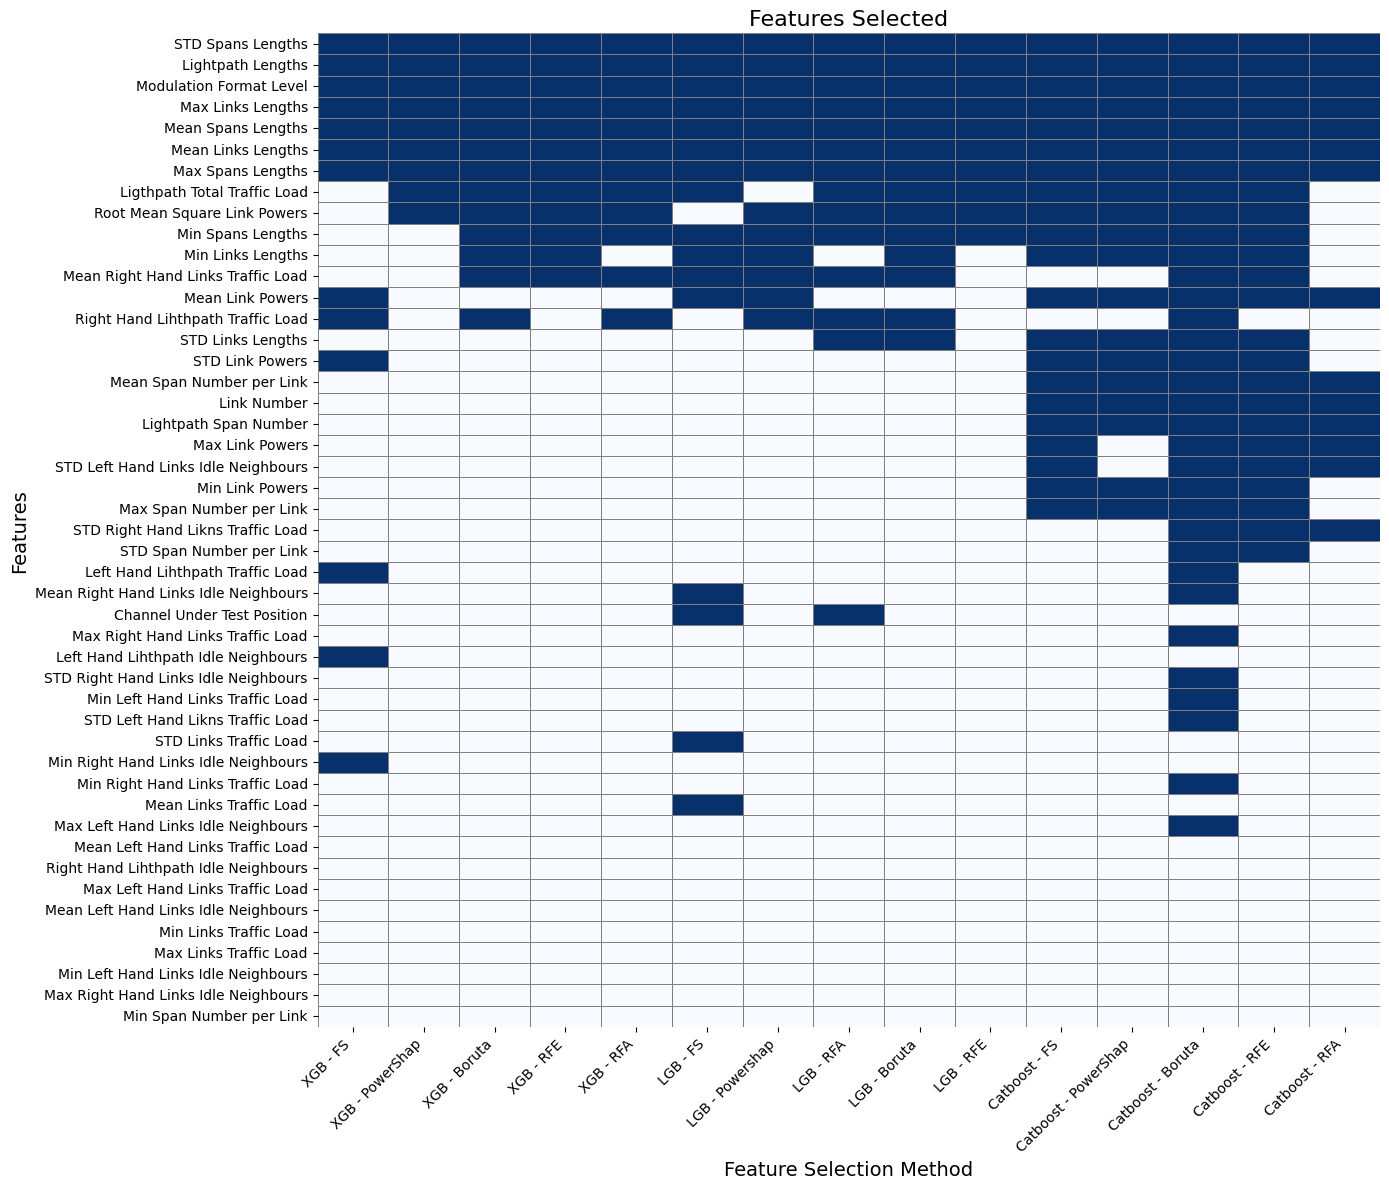

In [ ]:
updated_features_data = pd.read_csv("selected_features.csv")
updated_features_data['Method_Type'] = updated_features_data['type'] + " - " + updated_features_data['Feature_Selection_Method']
selected_columns = df.iloc[:, :-1]

updated_binary_matrix = pd.DataFrame(index=sorted(list(selected_columns)), columns=updated_features_data['Method_Type'])

for index, row in updated_features_data.iterrows():
    method = row['Method_Type']
    for feature in row['Selected_Features'].split(', '):
        updated_binary_matrix.at[feature, method] = 1

updated_binary_matrix.fillna(0, inplace=True)

sorted_features_updated = updated_binary_matrix.sum(axis=1).sort_values(ascending=False).index

sorted_updated_binary_matrix = updated_binary_matrix.loc[sorted_features_updated]

plt.figure(figsize=(14, 12))
sns.heatmap(sorted_updated_binary_matrix, cmap="Blues", cbar=False, linewidths=0.5, linecolor='gray')

plt.title("Features Selected", fontsize=16)
plt.xlabel("Feature Selection Method", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
